# Random Forest
Haytham Mohamed

INFS 890 - Spring 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [2]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [3]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [4]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

front-end_cpu_use  orders_cpu_use  orders-db_cpu_use  user_cpu_use  \
0             0.0700          0.0200             0.0100        0.0200   
1             0.0600          0.0300             0.0100        0.0200   
2             0.2100          0.0600             0.0200        0.0500   
3             0.2200          0.0600             0.0200        0.0600   
4             0.2100          0.0600             0.0100        0.0500   

   user-db_cpu_use  shipping_cpu_use  payment_cpu_use  carts_cpu_use  \
0           0.0200            0.0100           0.0100         0.1200   
1           0.0200            0.0100           0.0100         0.1400   
2           0.0300            0.0200           0.0100         0.2400   
3           0.0400            0.0200           0.0100         0.2100   
4           0.0400            0.0200           0.0100         0.1500   

   carts-db_cpu_use  front-end_pods  ...  user-db_net_use  shipping_net_use  \
0            0.1600          1.0000  ...           9.1583            4.2628   
1            0.1700          1.0000  ...           8.2344            4.8656   
2            0.6600          1.0000  ...          25.5465            3.1148   
3            0.6600          1.0000  ...          26.4822            7.2076   
4            0.6600          1.0000  ...          18.6872            6.8741   

   payment_net_use  carts_net_use  carts-db_net_use  nodes_cpu_use  \
0           3.3626         6.9149            5.5572         1.1800   
1           3.1404         9.7259            7.1883         1.1800   
2           4.4254        29.5804            7.4301         1.8400   
3           4.4523        25.2584           15.2118         1.8300   
4           6.0157        24.1570           16.1607         1.7500   

   nodes_disk_io  nodes_net_use  orders_req  orders_ltcy  
0         0.0000         1.7850      0.4000       0.4000  
1         0.0000         1.7496      0.4400       0.3900  
2         0.2600         3.6912      1.5800       0.4200  
3         0.2600         3.7957      1.5800       0.4100  
4         0.0000         3.8370      1.4900       0.3900  

[5 rows x 29 columns]

In [5]:
data.shape

(3175, 29)

In [6]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 28 features


In [7]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [8]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


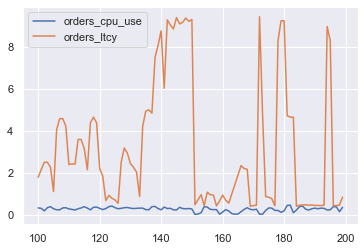

In [9]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [10]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

#rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
#sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

sfm = PCA(random_state=100)

reg = RandomForestRegressor()

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    
    #'selector__threshold': ['0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    #, 'selector__estimator__max_depth' : [10, 15]
    #, 'selector__estimator__n_estimators' : [20, 30, 40]
    
    'selector__n_components' : [10, 15, 20]  # with PCA
    
    , 'reg__max_features': [13, 11, 9]   # The maximum number of features to consider
    , 'reg__n_estimators': [10, 8, 6]  # The number of trees in the forest 
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [11]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.3s finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None, random_state=100,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('reg',
                                        RandomForestRegressor(bootstrap=T...
                                                              min_weight_fraction_leaf=0.0,
                                      

# Best Model

In [12]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0603:
Best CV params = {'reg__max_features': 9, 'reg__n_estimators': 8, 'selector__n_components': 20}


# Features Selected

In [13]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

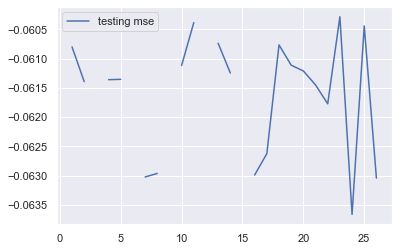

In [14]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [15]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.6339880660629
Score (training) = -0.043341573627643445


In [16]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.35 (0.24) 0.00 1.00 MSE


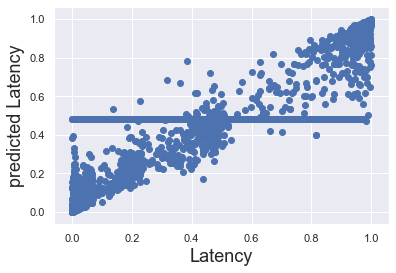

In [17]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

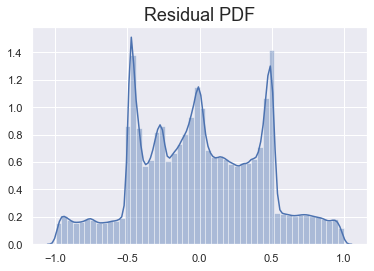

In [18]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [19]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

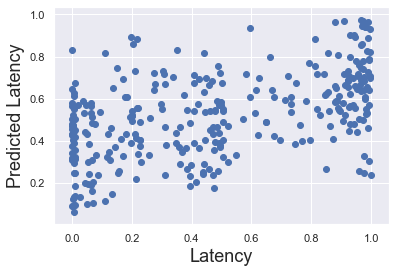

In [20]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

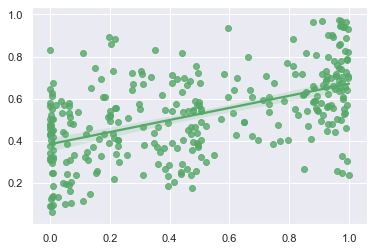

In [21]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [22]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

prediction  target
0      0.0879  0.0016
1      0.2473  0.0071
2      0.3573  0.0093
3      0.4685  0.0027
4      0.4793  0.0016

In [23]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0        0.0879  0.0016    0.0863   5,468.5393
1        0.2473  0.0071    0.2403   3,395.2381
2        0.3573  0.0093    0.3480   3,752.0076
3        0.4685  0.0027    0.4658  17,393.8742
4        0.4793  0.0016    0.4778  30,268.5393
..          ...     ...       ...          ...
313      0.6428  0.9945   -0.3517      35.3674
314      0.9320  0.9967   -0.0647       6.4952
315      0.5675  0.9945   -0.4271      42.9412
316      0.5716  0.9384   -0.3668      39.0920
317      0.5977  0.9780   -0.3803      38.8870

[318 rows x 4 columns]

In [24]:
perf.describe()

prediction   target  residual  difference%
count    318.0000 318.0000  318.0000     318.0000
mean       0.5223   0.4823    0.0400   3,253.9851
std        0.2020   0.3622    0.3108  13,711.1776
min        0.0637   0.0005   -0.7619       0.1837
25%        0.3869   0.1302   -0.2084      23.0298
50%        0.5312   0.4585    0.0335      44.3874
75%        0.6630   0.8859    0.2826     199.3112
max        0.9754   1.0000    0.8276 117,713.8889

In [25]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
289        0.97    0.97     -0.00         0.18
291        0.98    0.97      0.01         0.87
109        0.47    0.47     -0.01         1.08
129        0.22    0.21      0.00         1.92
297        0.71    0.72     -0.01         1.95
305        0.95    0.97     -0.02         2.05
146        0.45    0.46     -0.01         2.18
246        0.61    0.59      0.01         2.47
282        0.94    0.97     -0.02         2.53
266        0.96    0.99     -0.03         2.58
271        0.90    0.93     -0.03         2.83
288        0.77    0.79     -0.02         3.07
212        0.37    0.36      0.01         3.26
165        0.49    0.51     -0.02         3.75
116        0.37    0.38     -0.01         3.82
265        0.94    0.98     -0.04         4.02
268        0.64    0.67     -0.03         4.05
312        0.94    0.98     -0.04         4.10
119        0.64    0.61      0.03         4.12
309        0.90    0.94     -0.04         4.27
135        0.81    0.85     -0.04         4.71
196        0.46    0.49     -0.02         4.80
224        0.39    0.41     -0.02         5.25
68         0.12    0.11      0.01         5.28
179        0.35    0.37     -0.02         5.44
290        0.89    0.95     -0.06         5.93
294        0.97    0.91      0.06         6.35
314        0.93    1.00     -0.06         6.50
137        0.54    0.51      0.03         6.87
121        0.75    0.81     -0.06         6.92
293        0.88    0.81      0.07         8.37
79         0.43    0.47     -0.04         8.42
45         0.14    0.13      0.01         8.44
123        0.55    0.51      0.05         9.01
174        0.41    0.45     -0.04         9.10
281        0.81    0.89     -0.08         9.31
100        0.47    0.52     -0.05         9.50
264        0.96    0.88      0.09         9.71
134        0.67    0.75     -0.08        10.11
188        0.61    0.67     -0.07        10.15
274        0.89    0.99     -0.10        10.25
197        0.44    0.49     -0.05        11.01
296        0.86    0.97     -0.11        11.12
295        0.86    0.96     -0.11        11.28
169        0.70    0.62      0.07        11.61
153        0.39    0.35      0.04        12.44
206        0.50    0.57     -0.07        12.47
120        0.72    0.82     -0.10        12.53
186        0.54    0.48      0.06        12.83
164        0.53    0.61     -0.08        13.48
110        0.57    0.50      0.07        13.70
80         0.36    0.42     -0.06        14.10
89         0.80    0.93     -0.13        14.11
125        0.55    0.48      0.07        14.59
177        0.72    0.84     -0.13        15.00
87         0.57    0.49      0.07        15.16
300        0.83    0.99     -0.16        16.49
261        0.61    0.73     -0.12        16.78
112        0.54    0.46      0.08        16.81
78         0.58    0.50      0.08        16.82
190        0.59    0.71     -0.12        16.94
166        0.39    0.48     -0.08        17.59
308        0.82    1.00     -0.18        17.63
272        0.78    0.95     -0.17        17.92
128        0.29    0.36     -0.07        19.37
242        0.80    0.66      0.13        19.93
276        0.78    0.97     -0.20        20.17
124        0.40    0.50     -0.10        20.20
77         0.54    0.44      0.09        20.49
301        0.76    0.96     -0.20        20.56
277        0.73    0.92     -0.19        20.66
126        0.39    0.49     -0.10        20.66
286        0.79    0.99     -0.21        20.79
273        0.79    0.99     -0.21        20.82
141        0.38    0.31      0.07        20.86
303        0.72    0.91     -0.19        21.01
111        0.59    0.48      0.10        21.60
262        0.57    0.73     -0.16        21.62
299        0.75    0.97     -0.22        22.63
199        0.38    0.49     -0.11        23.00
106        0.48    0.39      0.09        23.12
285        0.71    0.93     -0.22        23.46
227        0.72    0.58      0.14        23.51
99         0.24    0.31     -0.07        23.76
307       

# *** Prediction Accuracy

In [26]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.251554051631824


In [27]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.3128805601558111
